In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
%load_ext line_profiler
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from merf.utils import MERFDataGenerator
from merf.merf import MERF

# Test Data Generation

In [3]:
dgm = MERFDataGenerator(m=.6, sigma_b=np.sqrt(4.5), sigma_e=1)

In [4]:
num_clusters_each_size = 20
train_sizes = [1, 3, 5, 7, 9]
known_sizes = [9, 27, 45, 63, 81]
new_sizes = [10, 30, 50, 70, 90]

In [5]:
# Smaller set that can be used for debugging
# num_clusters_each_size = 1
# train_sizes = [1, 3]
# known_sizes = [9, 27]
# new_sizes = [10, 30]

In [6]:
train_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(train_sizes, num_clusters_each_size)
known_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(known_sizes, num_clusters_each_size)
new_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(new_sizes, num_clusters_each_size)

In [7]:
len(train_cluster_sizes), len(known_cluster_sizes), len(new_cluster_sizes)

(100, 100, 100)

In [8]:
train, test_known, test_new, training_cluster_ids, ptev, prev = dgm.generate_split_samples(train_cluster_sizes, known_cluster_sizes, new_cluster_sizes)

INFO     [utils.py:165] Drew 10000 samples from 200 clusters.
INFO     [utils.py:166] PTEV = 89.82812678595542, PREV = 50.956678159693325.


In [9]:
len(train), len(test_known), len(test_new)

(500, 4500, 5000)

In [10]:
train.head()

,y,X_0,X_1,X_2,Z,cluster
0,1.945204,-1.398591,1.305266,1.488496,1.0,0
10,5.319169,1.465689,-0.867374,1.849228,1.0,1
20,-1.508752,0.671516,0.318205,-1.496462,1.0,2
30,1.711938,-0.150823,-1.032354,0.505866,1.0,3
40,6.329901,-0.016230,0.678882,-1.227977,1.0,4


# MERF Training

In [11]:
X_train = train[['X_0', 'X_1', 'X_2']]
Z_train = train[['Z']]
clusters_train = train['cluster']
y_train = train['y']

In [12]:
mrf = MERF(n_estimators=300, max_iterations=10)
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:256] GLL is 1117.5252416868304 at iteration 1.
INFO     [merf.py:256] GLL is 957.6755869041319 at iteration 2.
INFO     [merf.py:256] GLL is 943.8926868286338 at iteration 3.
INFO     [merf.py:256] GLL is 938.1834513139264 at iteration 4.
INFO     [merf.py:256] GLL is 941.8298575127147 at iteration 5.
INFO     [merf.py:256] GLL is 936.7193444240221 at iteration 6.
INFO     [merf.py:256] GLL is 939.8534468953775 at iteration 7.
INFO     [merf.py:256] GLL is 940.133622774253 at iteration 8.
INFO     [merf.py:256] GLL is 936.4195725602539 at iteration 9.
INFO     [merf.py:256] GLL is 933.3515074668917 at iteration 10.


Text(0.5, 0, 'Iteration')

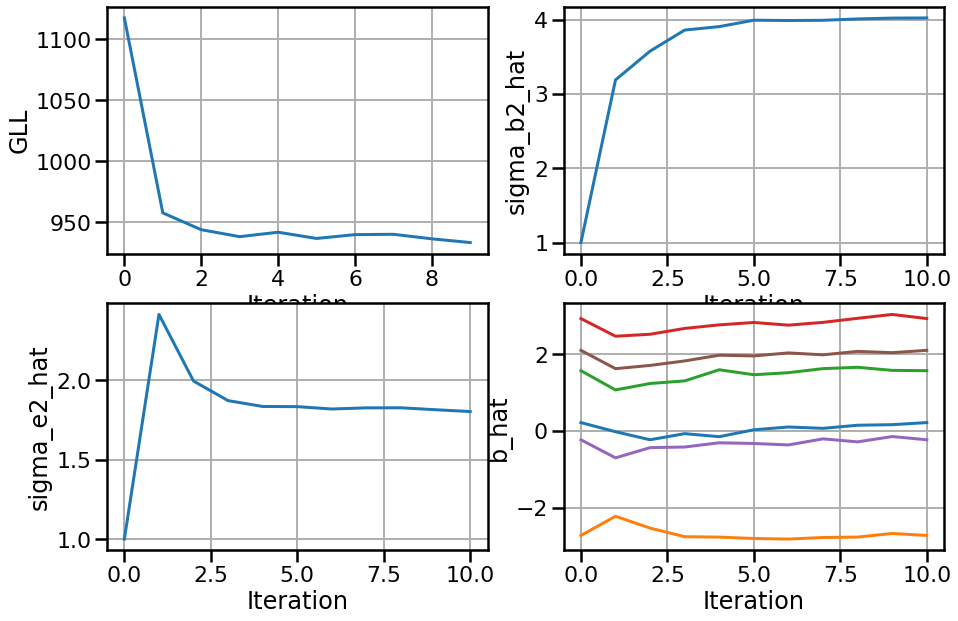

In [13]:
plt.figure(figsize=[15,10])
plt.subplot(221)
plt.plot(mrf.gll_history)
plt.grid('on')
plt.ylabel('GLL')
plt.xlabel('Iteration')

plt.subplot(222)
D_hat_history = [x[0][0] for x in mrf.D_hat_history]
plt.plot(D_hat_history)
plt.grid('on')
plt.ylabel('sigma_b2_hat')
plt.xlabel('Iteration')

plt.subplot(223)
plt.plot(mrf.sigma2_hat_history)
plt.grid('on')
plt.ylabel('sigma_e2_hat')
plt.xlabel('Iteration')

plt.subplot(224)
b_df = pd.concat(mrf.b_hat_history, axis=1)
b_df.columns = range(0, 11)
plt.plot(b_df.loc[0])
plt.plot(b_df.loc[20])
plt.plot(b_df.loc[30])
plt.plot(b_df.loc[40])
plt.plot(b_df.loc[50])
plt.plot(b_df.loc[60])
plt.grid('on')
plt.ylabel('b_hat')
plt.xlabel('Iteration')

Text(0.5, 1.0, 'Distribution of b_is')

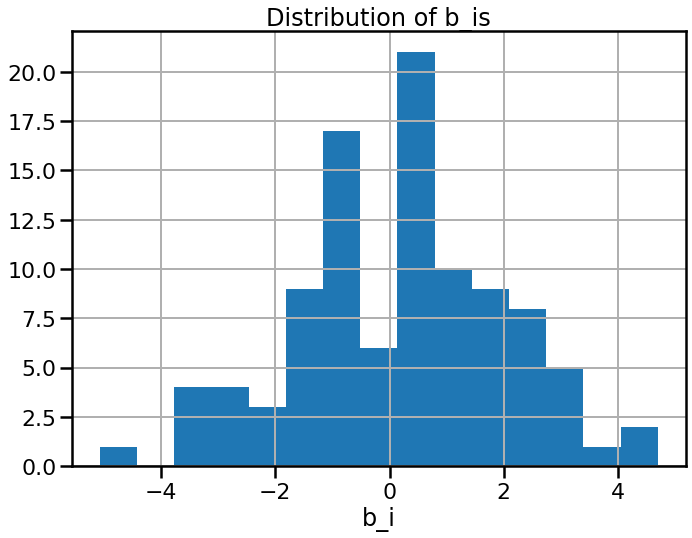

In [14]:
mrf.trained_b.hist(bins=15)
plt.xlabel('b_i')
plt.title('Distribution of b_is')

# MERF Prediction

In [15]:
X_known = test_known[['X_0', 'X_1', 'X_2']]
Z_known = test_known[['Z']]
clusters_known = test_known['cluster']
y_known = test_known['y']

In [16]:
y_hat_known = mrf.predict(X_known, Z_known, clusters_known)
y_hat_known

array([0.82620506, 2.23538033, 4.80797432, ..., 0.78548974, 2.43985485,
       5.6226982 ])

In [17]:
assert len(y_hat_known) == len(y_known)

In [18]:
X_new = test_new[['X_0', 'X_1', 'X_2']]
Z_new = test_new[['Z']]
clusters_new = test_new['cluster']
y_new = test_new['y']

In [19]:
y_hat_new = mrf.predict(X_new, Z_new, clusters_new)
y_hat_new

array([0.99744384, 0.83161287, 4.59548916, ..., 2.88581756, 4.03552885,
       2.16810783])

In [20]:
assert len(y_hat_new) == len(y_new)

# Inspect Trained Random Forest

Specifically look at the partial dependence plots and feature importance (using SHAP). 

In [22]:
mrf.trained_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [23]:
from sklearn.inspection import plot_partial_dependence

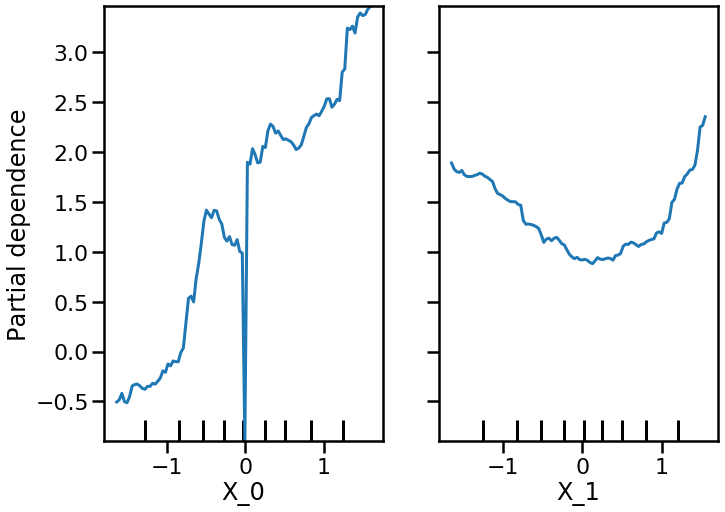

In [24]:
features = [0, 1]
plot_partial_dependence(mrf.trained_rf, X_known, features) 

In [21]:
import shap

In [25]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(mrf.trained_rf)
shap_values = explainer.shap_values(X_known)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


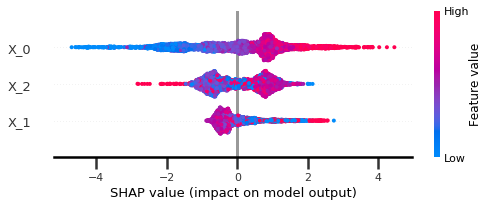

In [26]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_known)

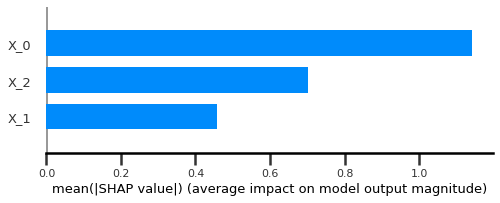

In [27]:
shap.summary_plot(shap_values, X_known, plot_type="bar")


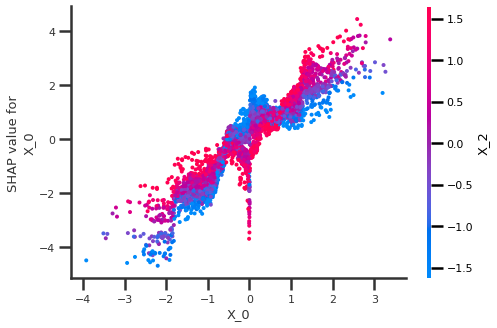

In [29]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('X_0', shap_values, X_known)

# MERF vs. Random Forest on Fixed Effects

In [30]:
# Train and test using classic random forest. 
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [31]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [32]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [33]:
y_hat_known_rf = rf.predict(X_known)

In [34]:
pmse_known_rf = np.mean((y_known - y_hat_known_rf) ** 2)
pmse_known_rf

6.533292842393395

In [35]:
y_hat_known_merf = mrf.predict(X_known, Z_known, clusters_known)

In [36]:
pmse_known_merf = np.mean((y_known - y_hat_known_merf) ** 2)
pmse_known_merf

2.0750830331084815

In [37]:
rd_known = 100 * (pmse_known_rf - pmse_known_merf) / pmse_known_rf
rd_known

68.23832815753137

In [38]:
y_hat_new_rf = rf.predict(X_new)

In [39]:
pmse_new_rf = np.mean((y_new - y_hat_new_rf) ** 2)
pmse_new_rf

6.9108742851805

In [40]:
y_hat_new_merf = mrf.predict(X_new, Z_new, clusters_new)

In [41]:
pmse_new_merf = np.mean((y_new - y_hat_new_merf) ** 2)
pmse_new_merf

6.607323094524316

In [42]:
rd_new = 100 * (pmse_new_rf - pmse_new_merf) / pmse_new_rf
rd_new

4.392370315679322

# MERF vs Random Forest with OHE Cluster Ids

In [82]:
rf_ohe = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [83]:
categories = np.sort(clusters_train.unique())

In [84]:
clusters_train_prime = pd.Categorical(clusters_train, categories=categories)

In [85]:
X_ohe = pd.get_dummies(clusters_train_prime, prefix='cluster')

In [86]:
X_ohe.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_90,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
X_train_ohe = pd.merge(X_train, X_ohe, left_index=True, right_index=True)

In [88]:
rf_ohe.fit(X_train_ohe, y_train)

ValueError: Number of labels=500 does not match number of samples=50

In [76]:
clusters_known_prime = pd.Categorical(clusters_known, categories=categories)

In [77]:
X_known_ohe = pd.get_dummies(clusters_known_prime, prefix='cluster')

In [78]:
X_known_ohe.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_90,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
X_known_w_ohe = pd.merge(X_known, X_known_ohe, left_index=True, right_index=True)

In [80]:
y_hat_known_rf_ohe = rf_ohe.predict(X_known_w_ohe)

IndexError: list index out of range

In [81]:
mse_known_rf_ohe = np.mean((y_known - y_hat_known_rf_ohe) ** 2)
mse_known_rf_ohe

4.523357228389983

In [61]:
clusters_new_prime = pd.Categorical(clusters_new, categories=categories)

In [62]:
X_new_ohe = pd.get_dummies(clusters_new_prime, prefix='cluster')

In [63]:
X_new_ohe.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_90,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X_new_w_ohe = pd.merge(X_new, X_new_ohe, left_index=True, right_index=True)

In [65]:
y_hat_new_rf_ohe = rf_ohe.predict(X_new_w_ohe)

ValueError: Found array with 0 sample(s) (shape=(0, 103)) while a minimum of 1 is required.

In [67]:
mse_new_rf_ohe = np.mean((y_new - y_hat_new_rf_ohe) ** 2)
mse_new_rf_ohe

NameError: name 'y_hat_new_rf_ohe' is not defined